<a href="https://colab.research.google.com/github/1rd0/18lab_bek/blob/master/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%96_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация текстов в Keras

---

**ФИО:**
Рабдел Дмитрий Александрович

---


Задание: создать модель для решения задачи классификации текста - определение тональности отзывов с использованием фреймворка Keras.

В этой работе булем решать задачу определение тональности отзывов с использованием фреймворка Keras. В ноутбуке ниже приведен пример создания нейронной сети для классификаци
и текстов на датасете, состоящим из отзывов на Tesla, бинарная лкассификация - 2 класса - позитивный отзыв и негативный отзыв. (Ссылка на датасет в примере https://drive.google.com/file/d/1PKL86ByMBl0M_rWjcjgoO29ojh9QmTU8/view?usp=sharing )

В задании для самостоятельной разработки необходимо загрузить датасет и построить 2 архитектуры сети (с использованием слоев Conv1D и SimpleRNN), вывести результаты обучения.

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
import os
import re

import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from itertools import chain
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, SimpleRNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


####
Создать нейронную сеть по распознаванию позитивных и негативных отзывы
людей по автомобилю Tesla. (tesla.zip).

In [7]:
import os

In [9]:
zip_path = '/content/tesla.zip'



In [10]:
!unzip -qo -O UTF-8 tesla.zip -d tesla/

In [12]:
def read_text(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read().replace("\n", " ")
    return text

class_names = ["positive", "negative"]
num_classes = len(class_names)
texts_list = []

for i in os.listdir('/content/tesla/'):
    texts_list.append(read_text('/content/tesla/' + i))
    print(i, 'добавлен в обучающую выборку')

texts_len = [len(text) for text in texts_list]

# Разделение на тренировочную и тестовую выборки
train_data = []
test_data = []

for text in texts_list:
    train_len = int(len(text) * 0.8)
    train_data.append(text[:train_len])
    test_data.append(text[train_len:])

VOCAB_SIZE = 5000
WIN_SIZE = 500
WIN_HOP = 100

# Создание токенайзера и обучение
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, oov_token='неизвестное_слово')
tokenizer.fit_on_texts(train_data)

# Преобразование текстов в последовательности
seq_train = tokenizer.texts_to_sequences(train_data)
seq_test = tokenizer.texts_to_sequences(test_data)

# Функция разбиения последовательности на отрезки
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

# Функция формирования выборок из последовательностей
def vectorize_sequence(seq_list, win_size, hop):
    x, y = [], []
    for cls, sequences in enumerate(seq_list):
        vectors = split_sequence(sequences, win_size, hop)
        x.extend(vectors)
        y.extend([to_categorical(cls, num_classes)] * len(vectors))
    return np.array(x), np.array(y)

# Формирование обучающей и тестовой выборок
x_train, y_train = vectorize_sequence([seq_train], WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence([seq_test], WIN_SIZE, WIN_HOP)


Негативный отзыв.txt добавлен в обучающую выборку
Позитивный отзыв.txt добавлен в обучающую выборку
[]


**Форимирование обучающего и тестового набора**

** Создание токенайзера**

In [13]:
# Создание токенайзера
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True,
    split=' ',
    oov_token='неизвестное_слово',
    char_level=False
)
# Обучение токенайзера

tokenizer.fit_on_texts(train_data)
items = list(tokenizer.word_index.items())

In [ ]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:10])
print("Размер словаря", len(items))

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('на', 5), ('это', 6), ('что', 7), ('с', 8), ('тесла', 9), ('за', 10)]
Размер словаря 10336


In [14]:
# Преобразование  в последовательность
seq_train = tokenizer.texts_to_sequences(train_data)
seq_test = tokenizer.texts_to_sequences(test_data)

In [15]:
# Функция разбиения последовательности на отрезки скользящим окном
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

# Функция формирования выборок из последовательностей индексов
def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)
    x, y = [], []
    for cls in range(class_count):
        vectors = split_sequence(seq_list[cls], win_size, hop)
        x += vectors
        y += [utils.to_categorical(cls, class_count)] * len(vectors)
    return np.array(x), np.array(y)

In [16]:
#  формирования обучающуся  и тесстовой выборок
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(418, 500) (418, 2)
(100, 500) (100, 2)


**Векторизация текста**

Преобразование в Bag of Words

#### Задание
1. Для загруженного датачета отзывов создайте 2 архитектуры сети с использованием слоев Conv1D и SimpleRNN с использованием векторизации Bag of Words и Embedding.
2. Обучите сеть, добейтесь результата точности сети не менее 90% на проверочной выборке модели с использованием векторизации Bag of Words и 80% - для модели Embedding.
3. Выведите архитектуры сетей.

4. Выведите результаты и постройте матрицу ошибок.

In [6]:
def read_text(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read().replace("\n", " ")
    return text

class_names = ["positive", "negative"]
num_classes = len(class_names)
texts_list = []

for i in os.listdir('/content/tesla/'):
    texts_list.append(read_text('/content/tesla/' + i))
    print(i, 'добавлен в обучающую выборку')

texts_len = [len(text) for text in texts_list]

# Разделение на тренировочную и тестовую выборки
train_data = []
test_data = []

for text in texts_list:
    train_len = int(len(text) * 0.8)
    train_data.append(text[:train_len])
    test_data.append(text[train_len:])

VOCAB_SIZE = 5000
WIN_SIZE = 500
WIN_HOP = 100

# Создание токенайзера и обучение
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, oov_token='неизвестное_слово')
tokenizer.fit_on_texts(train_data)

# Преобразование текстов в последовательности
seq_train = tokenizer.texts_to_sequences(train_data)
seq_test = tokenizer.texts_to_sequences(test_data)

# Функция разбиения последовательности на отрезки
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

# Функция формирования выборок из последовательностей
def vectorize_sequence(seq_list, win_size, hop):
    x, y = [], []
    for cls, sequences in enumerate(seq_list):
        vectors = split_sequence(sequences, win_size, hop)
        x.extend(vectors)
        y.extend([to_categorical(cls, num_classes)] * len(vectors))
    return np.array(x), np.array(y)

# Формирование обучающей и тестовой выборок
x_train, y_train = vectorize_sequence([seq_train], WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence([seq_test], WIN_SIZE, WIN_HOP)
print(len(x_train))

Негативный отзыв.txt добавлен в обучающую выборку
Позитивный отзыв.txt добавлен в обучающую выборку
0


Модели с Bag of Words

In [17]:
# Преобразование последовательностей в матрицы
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

# Модель на основе Bag of Words с Conv1D
model_bow_conv1d = Sequential([
    Dense(128, input_shape=(VOCAB_SIZE,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_bow_conv1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bow_conv1d_history = model_bow_conv1d.fit(x_train_01, y_train, epochs=10, validation_split=0.1)

# Модель на основе Bag of Words с SimpleRNN
model_bow_rnn = Sequential([
    Dense(128, input_shape=(VOCAB_SIZE,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_bow_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bow_rnn_history = model_bow_rnn.fit(x_train_01, y_train, epochs=10, validation_split=0.1)


Epoch 1/10
12/12 [==============================] - 1s 52ms/step - loss: 0.3361 - accuracy: 0.9229 - val_loss: 0.1520 - val_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 0s 13ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 0s 12ms/step - loss: 1.3349e-04 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 0s 12ms/step - loss: 3.7309e-05 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 0s 13ms/step - loss: 2.3350e-05 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 0s 11ms/step - loss: 1.9428e-05 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 0s 11ms/step - loss: 1.7954e-05 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 

In [18]:
# Модель на основе Embedding с Conv1D
model_embed_conv1d = Sequential([
    Embedding(VOCAB_SIZE, 200, input_length=WIN_SIZE),
    Conv1D(200, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='sigmoid')
])

model_embed_conv1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_embed_conv1d_history = model_embed_conv1d.fit(x_train, y_train, epochs=5, validation_split=0.1, batch_size=32)

# Модель на основе Embedding с SimpleRNN
model_embed_rnn = Sequential([
    Embedding(VOCAB_SIZE, 200, input_length=WIN_SIZE),
    SimpleRNN(200, activation='relu', return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='sigmoid')
])

model_embed_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_embed_rnn_history = model_embed_rnn.fit(x_train, y_train, epochs=5, validation_split=0.1, batch_size=32)


Epoch 1/5
12/12 [==============================] - 6s 367ms/step - loss: 0.6371 - accuracy: 0.6223 - val_loss: 0.5391 - val_accuracy: 1.0000
Epoch 2/5
12/12 [==============================] - 5s 406ms/step - loss: 0.3971 - accuracy: 0.9814 - val_loss: 0.4841 - val_accuracy: 1.0000
Epoch 3/5
12/12 [==============================] - 6s 457ms/step - loss: 0.1075 - accuracy: 1.0000 - val_loss: 0.4145 - val_accuracy: 1.0000
Epoch 4/5
12/12 [==============================] - 4s 357ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.2294 - val_accuracy: 1.0000
Epoch 5/5
12/12 [==============================] - 4s 378ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1663 - val_accuracy: 1.0000
Epoch 1/5
12/12 [==============================] - 5s 334ms/step - loss: 0.6549 - accuracy: 0.5745 - val_loss: 0.5897 - val_accuracy: 1.0000
Epoch 2/5
12/12 [==============================] - 8s 730ms/step - loss: 0.4702 - accuracy: 0.9867 - val_loss: 0.4543 - val_accuracy: 1.0000
Epoch 3/5
12/

4/4 [==============================] - 0s 4ms/step


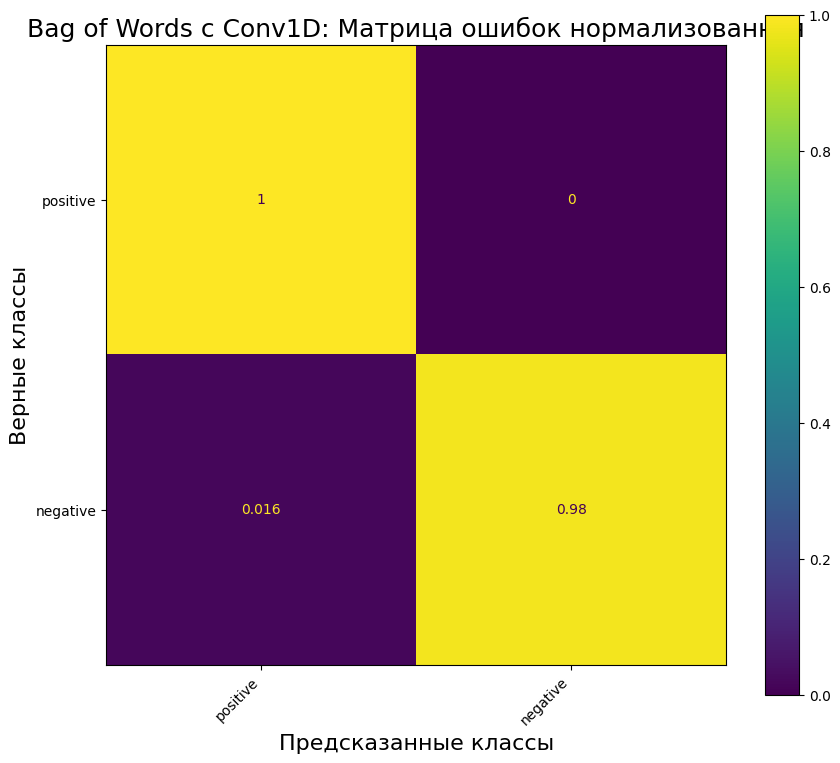

4/4 [==============================] - 0s 4ms/step


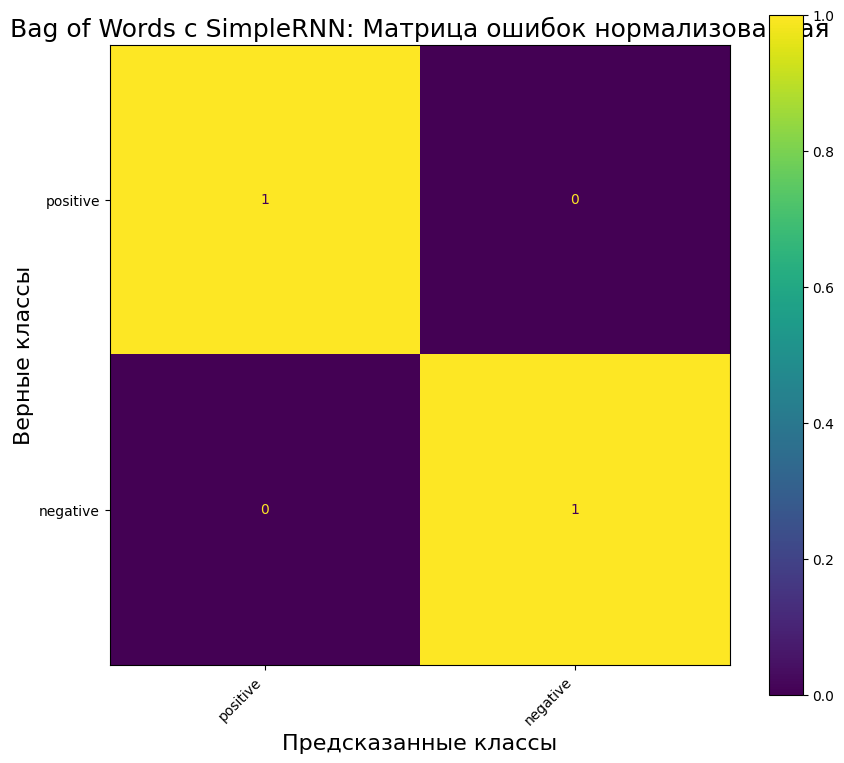

4/4 [==============================] - 0s 77ms/step


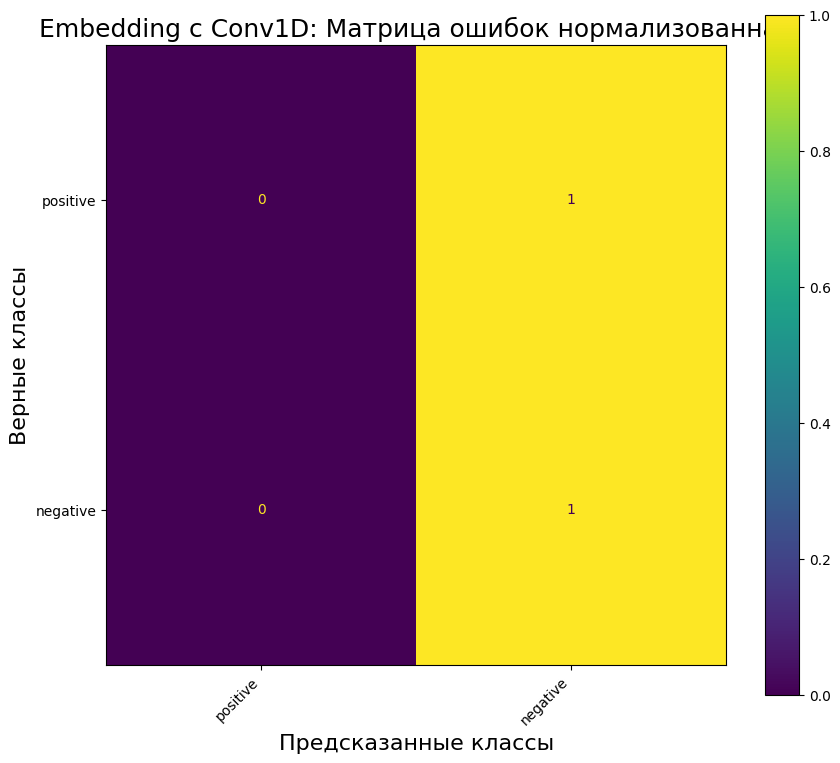

4/4 [==============================] - 0s 66ms/step


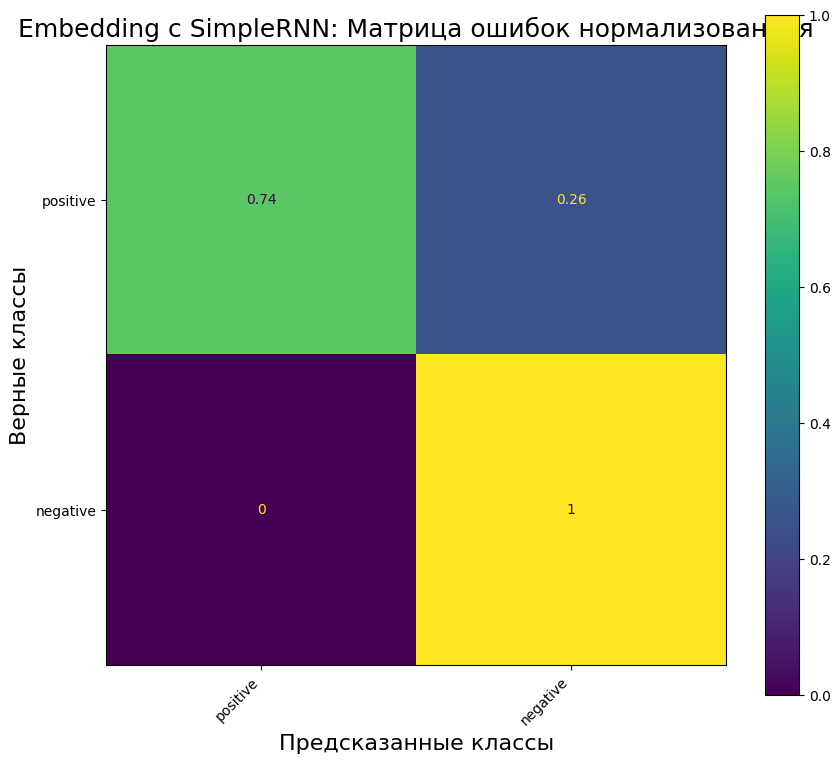

In [19]:
def evaluate_model(model, x_test, y_test, title):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='true')
    cm = np.around(cm, 3)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'{title}: Матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax)
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)
    plt.show()

# Оценка моделей на основе Bag of Words
evaluate_model(model_bow_conv1d, x_test_01, y_test, 'Bag of Words с Conv1D')
evaluate_model(model_bow_rnn, x_test_01, y_test, 'Bag of Words с SimpleRNN')

# Оценка моделей на основе Embedding
evaluate_model(model_embed_conv1d, x_test, y_test, 'Embedding с Conv1D')
evaluate_model(model_embed_rnn, x_test, y_test, 'Embedding с SimpleRNN')


## Контрольные вопросы

**Опишите для чего нужен и как работает tokenizer**

Ваш ответ:
Tokenizer нужен для преобразования текста в числа, чтобы нейронные сети могли работать с текстовыми данными. Он разбивает текст на слова (токены) и заменяет их на уникальные числа.

**Опишите параметры tokenizer**

Ваш ответ:
num_words: Максимальное количество уникальных слов.

filters: Символы, которые будут удалены из текста.
lower: Преобразует текст в нижний регистр.

split: Символ для разделения текста на слова.
char_level: Если True, каждый символ рассматривается как отдельный токен.

oov_token: Токен для редких или неизвестных слов.

**Объясните концепцию векторизации Bag of Words.**

Ваш ответ:
Bag of Words (мешок слов) преобразует текст в числовые векторы. В каждом векторе подсчитывается, сколько раз каждое слово из словаря встречается в тексте. Это позволяет представлять тексты в виде чисел.



**Опишите слой Embedding и его параметры**

Ваш ответ:
Слой Embedding преобразует слова в плотные векторы. Эти векторы помогают нейронной сети лучше понимать текст.

input_dim: Размер словаря (количество уникальн
ых слов).

output_dim: Размерность выходных векторов.

input_length: Длина входных последовательностей (число слов в тексте).








